# Снижение дисперсии при A/B тесировании с помощью контрольных перменных, описанное в разделе 3 отчета о НИР.

Предположим, что в процессе проведения A/B теста нам доступны пары наблюдений $(X_i, Y_i)_{i=1}^n$, где $X_i$ и $y_i~-~$ признаки и значение целевой метрики для $i$-го пользователя соотвественно. Суть метода контрольных переменных заключается в том, чтобы на основании значения признаков $X$ построить такую случайную величину $\zeta$ с известным математическим ожиданием и конечной дисперсией, что
$$
Var(Y +\zeta) \ll Var(Y)\,.
$$
В таком случае выводы о наличие эффекта при A/B тестировании будут делаться на основании разницы в средних, обнаруживаемой в наборе величин $\{Y_i + \zeta_i\}$, обладающих меньшей дисперсией. Таким образом, за счет снижения дисперсии $\{Y_i + \zeta_i\}$ можно снизить размер выборки, требуемый для получения статистически значимых результатов.

In [76]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from tqdm.notebook import tqdm
import joblib
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder
from scipy import stats

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline

In [77]:
def get_coef_significance(X, Y): 
    """
    Функция для оценки статистической значимость коэффициентов линейной регрессии

    Параметры:
        X - DataFrame - данные, содержащие несколько объектов с признаками
        Y - array - целевая метрика для объектов из X

    Выход:
        table - DataFrame - таблица со значениями p-value, относительно которых можно делать вывод о статистической значимости коэффициента при каждом признаке в X.
        lin_reg - statsmodels.OLS - обученная модель регрессии
    """
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y

    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    table = pd.read_html(summary.as_html(), header=0, index_col=0)[0]
    return table, lin_reg

In [78]:
def check_pval(pval):
    """
    Функция для автоматической проверки p-value на статистическую значимость

    Параметры:
        pval - float - значение p-value
    """  
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [79]:
def ttest(x, y, randomized=False, verbose=False):
    """
    Функция для проведения T-testa в двух модификациях: с обычной и с рандомизированной T-статистикой.

    Параметры:
        x - array - значение целевой метрики в тестовой группе
        y - array - значение целевой метрики в контрольной группе
        randomized - bool - индикатор того, какой тест проводить (рандомизированный - 1, стандартный - 0)
        verbose - bool - печатать ли вспомогательную информацию
        
    Выход:
         полученное в T-тесте p-value (float)
    """ 
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    
    if randomized:
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        
        dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
        
        
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        
        theta_x = theta_x[:n_x]

        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        
        theta_y = theta_y[:n_y]

        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        p = 2*(stats.t.cdf(-abs(t_val), dof))
        
    else: 
        t_val, p = stats.ttest_ind(x, y, equal_var=False) 
        
    if verbose:
        check_pval(p)
    return p

# Обработка датасета и генерация подвыборок

In [6]:
## Для скачивания датасета раскомментировать следующий код

# !wget http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz
# !gzip -d criteo-uplift-v2.1.csv.gz 

inp_df = pd.read_csv('criteo-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')
df = inp_df 

X = features
y = 'visit'
t = 'treatment'

In [8]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [9]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'p-value по всем данных: {p}')

p-value по всем данных: 0.0


## Генерация стратифицированной подвыборки меньшего размера

В данной подвыборке с помощью стандартного Т-теста нулевая гипотеза 
$$\mathcal{H_0}: \mu_1 = \mu_2\, ,$$
не отвергается при истинности альтернативной
$$\mathcal{H_1}: \mu_1 \neq \mu_2\, ,$$

где $\mu_1$ и $\mu_2$ - математические ожидания в тестовой и контрольной выборках. Таким образом, размеры сгенерированных подвыборок недостаточны для того, чтобы обнаружить величину эффекта, равную $\mu_1 - \mu_2$.

Стратифицированная подвыборка генерируется с помощью MultilabelStratifiedShuffleSplit

In [10]:
columns = ['f0', 'f2', 'f8', 'f9', 'visit']
columns

['f0', 'f2', 'f8', 'f9', 'visit']

In [11]:
all_control = df.loc[df['treatment'] == 0]
all_treatment = df.loc[df['treatment'] == 1]

In [12]:
scale = all_treatment.shape[0] / all_control.shape[0]
scale

5.666672389299249

In [13]:
# # Можно не запускать код ниже в этой секции, а скачать сохраненную подвыборку

# control_sample = joblib.load('saved_variables/control_sample.joblib')
# treatment_sample = joblib.load('saved_variables/treatment_sample.joblib')

In [12]:
size_control = 0.0005
scale = all_treatment.shape[0] / all_control.shape[0]
size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=0)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=0)

In [44]:
trval_i, control_sample_i = next(msss_control.split(all_control.values, all_control.loc[:, columns].values))
trval_i, treatment_sample_i = next(msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values))

In [ ]:
control_sample = all_control.iloc[control_sample_i]
treatment_sample = all_treatment.iloc[treatment_sample_i]

In [15]:
print(f"treatment: {treatment_sample.shape[0]}, control: {control_sample.shape[0]}, frac: {treatment_sample.shape[0] / control_sample.shape[0]}")


treatment: 5941, control: 1049, frac: 5.663489037178265


In [16]:
# control_size = 0.0005

stats.ttest_ind(treatment_sample['visit'], control_sample['visit'], equal_var=False, random_state=1)

Ttest_indResult(statistic=1.5819821163140801, pvalue=0.1138575105831692)

In [17]:
print(f"Дисперсия в подвыборках: контроль {control_sample['visit'].var()}, тест {treatment_sample['visit'].var()}")

Дисперсия в подвыборках: контроль 0.036712536112182566, тест 0.046134463639932156


## Генерация исторического контекста

Генерация стартифицированной подвыборки, которая соответствует предэкспериментальному периоду.

Стратифицированная подвыборка генерируется с помощью MultilabelStratifiedShuffleSplit

In [14]:
# # Код ниже в этой секции можно не запускать, а скачать сохраненную подвыборку

# control_sample_hist = joblib.load('saved_variables/control_sample_hist.joblib')
# treatment_sample_hist = joblib.load('saved_variables/treatment_sample_hist.joblib')

In [17]:
all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample.index))]
all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample.index))]

In [14]:
size_control = 0.0005
scale = all_treatment_for_hist.shape[0] / all_control_for_hist.shape[0]
size_treatment = int(scale * size_control * all_control_for_hist.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=2)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=2)

In [ ]:
trval_i, control_sample_hist_i = next(msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values))
trval_i, treatment_sample_hist_i = next(msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values))

In [ ]:
control_sample_hist = all_control_for_hist.iloc[control_sample_hist_i]
treatment_sample_hist = all_treatment_for_hist.iloc[treatment_sample_hist_i]

In [19]:
print(f"treatment: {treatment_sample_hist.shape[0]}, control: {control_sample_hist.shape[0]}, frac: {treatment_sample_hist.shape[0] / control_sample_hist.shape[0]}")

treatment: 5938, control: 1048, frac: 5.666030534351145


## Генерация подвыборки с увеличивающимся размером

Генерация стратифицированных подвыборок размерами от 420 до 4200 с шагом 420 для эксперимента, описанного в разделе 3.4.1 отчета о НИР.

Стратифицированные подвыборки генерируются с помощью MultilabelStratifiedShuffleSplit

In [15]:
all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]

In [16]:
# ## Код ниже в этой секции можно не запускать, а скачать сохраненную подвыборку из папки saved_variables

# control_indexes_big = joblib.load('saved_variables/control_data_split_35e-5.joblib')
# treatment_indexes_big = joblib.load('saved_variables/treatment_data_split_35e-5.joblib')

# control_indexes_small = joblib.load('saved_variables/control_data_split_2e-4.joblib')
# treatment_indexes_small = joblib.load('saved_variables/treatment_data_split_2e-4.joblib')

# all_in_slit_control = []
# all_in_slit_treatment = []

# for i in tqdm(range(0, len(control_indexes_small))):
#     all_in_slit_control.extend(control_indexes_small[i].index)
#     all_in_slit_treatment.extend(treatment_indexes_small[i].index)
    
# for i in tqdm(range(0, len(control_indexes_big))):
#     all_in_slit_control.extend(control_indexes_big[i].index)
#     all_in_slit_treatment.extend(treatment_indexes_big[i].index)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [449]:
size_control = 0.00035

all_control.shape[0] * size_control

733.87825

In [450]:
size_control = 0.00035
scale = all_treatment.shape[0] / all_control.shape[0]
size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_control, random_state=3)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_treatment, random_state=3)

In [451]:
control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)

In [452]:
%%time

control_indexes = list(control_generator)
treatment_indexes = list(treatment_generator)

CPU times: user 34min 31s, sys: 19.1 s, total: 34min 50s
Wall time: 35min 1s


In [457]:
data_control = []
data_treatment = []

for i in tqdm(range(0, len(control_indexes))):
    data_control.append(all_control.iloc[control_indexes[i][1]])
    data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])

  0%|          | 0/10 [00:00<?, ?it/s]

# Методы снижения дисперсии при помощи контрольных переменных

## Метод CUPED из раздела 3.1 отчета о НИР

A. Deng, Y. Xu, R. Kohavi, T. Walker. "Improving the sensitivity of online controlled experiments by utilizing pre-experiment data"

In [73]:
def modify_with_cuped(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder="OHE", verbose=False):
    """
    Применение метода CUPED к контрольной и тестовой выборкам.
        

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        pipeline - bool - индикатор дополнительного преобразования признаков
        encoder - str - какой энкодер использовать, если pipeline=True
        verbose - bool - печатать ли впомогательную информацию 
    Выход:
        p-value - float - значение p-value до и после применения CUPED
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)
    
    Y = X['visit']
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))


    # Применение пайплайна обработки категориальных признаков (если pipeline=True) и обучение модели
    
    if pipeline:
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            verbose_feature_names_out=False,
        )

        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        
        reg.fit(X, Y)
        
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        means = np.mean(X)
        X = X - means

        reg = Pipeline(
            [
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        reg.fit(X, Y)
        
        
        c = control[columns] - means
        e = experimental[columns] - means

    

    y_c = control['visit']
    y_e = experimental['visit']

    # Изменение целевой переменной
    control_cuped = y_c - reg.predict(c) + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

## Метод CUPAC из раздела 3.2 отчета о НИР

A. Poyarkov, A. Drutsa, A. Khalyavin, G. Gusev, P. Serdyukov. "Boosted decision tree regression adjustment for variance reduction in online controlled experiments."

In [67]:
def modify_with_gb(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder='OHE', verbose=False):
    """
    Применение метода CUPAC к контрольной и тестовой выборкам

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        pipeline - bool - индикатор дополнительного преобразования признаков
        encoder - str - какой энкодер использовать, если pipeline=True
        verbose - bool - печатать ли впомогательную информацию 
    Выход:
        p-value - float - значение p-value до и после применения CUPAC
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)


    Y = X['visit']
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))
    
    # Применение пайплайна обработки категориальных признаков (если pipeline=True) и обучение модели
    if pipeline:
        
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            verbose_feature_names_out=False,
        )

        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2)),
            ]
        )
        reg.fit(X, Y)
        
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        means = np.mean(X)
        X = X - means
        
        reg = Pipeline(
            [
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2).fit(X, Y)),
            ]
        )
        reg.fit(X, Y)
    
        c = control[columns] - means
        e = experimental[columns] - means
    


    y_c = control['visit']
    y_e = experimental['visit']

    
    # Изменение целевой переменной
    control_cuped = y_c - reg.predict(c)  + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()

    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

## Метод ML-rate из раздела 3.3 отчета о НИР

Y. Guo, D. Coey, M. Konutgan, W. Li, C. Schoener, M. Goldman. "Machine learning for variance reduction in online experiments."

In [68]:
def modify_with_regression_test(control, experimental, control_hist, experimental_hist, columns, verbose=False, aa=False):
    """
    Применение метода Ml-rate к контрольной и тестовой выборкам

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        verbose - bool - печатать ли впомогательную информацию 
        aa - bool - проводится ли AA тест
    Выход:
        p-value - float - значение p-value до и после применения Ml-rate
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    
    if aa:
        experimental['treatment'] = 1
        
    Z = pd.concat((control, experimental, control_hist, experimental_hist), axis=0).sample(frac=1)
    means = np.mean(Z[columns])

    Y = Z['visit']
    X = Z[columns]
    X = X - means.values
    X = pd.concat((X, Z['treatment']), axis=1)
    
    # Обучение модели линейной регрессии
    table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X), Y)
    p_after = table_summary.iloc[-1, :]['P>|t|']
    
    return p_after

# Отбор признаков 

Для метода CUPED были выбраны наиболее значимые признаки из датасета при обучении линейной регрессии.

Для метода CUPAC - с помощью Permutation Feature Importance. Данный подход основан на том, что при изменении значений конкретного признака (путем случайной перестановки или перемешивания) и оценке влияния этого изменения на метрику качества модели можно определить, насколько важен этот признак для модели.

In [69]:
cols_regr_ordinal = ['f6', 'f8', 'f9', 'f0', 'f2']
cols_boosting = ['f2', 'f0', 'f9', 'f10', 'f4', 'f7', 'f8']

# Эксперимент с размером исторических данных из раздела 3.4.2 отчета о НИР

In [70]:
def draw_graphics(before=None, after_cup=None, after_gb=None, p_after_reg=None, title='', alpha=0.05):
    """
    Функция для отрисовки результатов работы методов

    Параметры:
        before - array - значения p-value для метода с использование изначальной целевой переменной
        after_cup - array - значения p-value для метода с использование целевой переменной, модифицированной методов CUPED
        after_gb - array - значения p-value для метода с использование целевой переменной, модифицированной методов CUPAC
        after_reg - array - значения p-value для метода с использование целевой переменной, модифицированной методов Ml-rate
        title - str - дополнительная над графиками
        alpha - float - уровень значимости
    """
    if len(title) != 0:
        print('\n', title, '\n')
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    ax1.plot(shapes, [alpha] * len(shapes), color="red", linestyle='dashed', label='alpha')
    if not (before is None):
        ax1.plot(shapes, before, marker='o', ms=5, label='Default')
        ax2.plot(shapes, np.log(before), marker='o', ms=5, label='Default')
    if not (after_cup is None):
        ax1.plot(shapes, after_cup, marker='o', ms=5, label='CUPED')
        ax2.plot(shapes, np.log(after_cup), marker='o', ms=5, label='CUPED')
    if not (after_gb is None):
        ax1.plot(shapes, after_gb, marker='o', ms=5, label='CUPAC')
        ax2.plot(shapes, np.log(after_gb), marker='o', ms=5, label='CUPAC')
    if not (p_after_reg is None):
        ax1.plot(shapes, p_after_reg, marker='o', ms=5, label='Ml-rate')
        ax2.plot(shapes, np.log(p_after_reg), marker='o', ms=5, label='Ml-rate')
    ax1.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax1.set_ylabel('p-value', fontsize=15)
#     ax1.set_title(f'Поведение p-value в зависимости от размера выборки', fontsize=15)

    ax2.plot(shapes, [np.log(alpha)] * len(shapes), color="red", linestyle='dashed', label='alpha')
    ax2.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax2.set_ylabel('log p-value', fontsize=15)
#     ax2.set_title(f'Поведение log p-value в зависимости от размера выборки',fontsize=15)

    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')

## Очень маленький исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [182]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist.sample(100, random_state=1)
    hist_e = treatment_sample_hist.sample(100, random_state=1)
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, hist_c, hist_e, cols3)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

  0%|          | 0/10 [00:00<?, ?it/s]


 Маленькие фолды: 420
Маленькая история: 200 



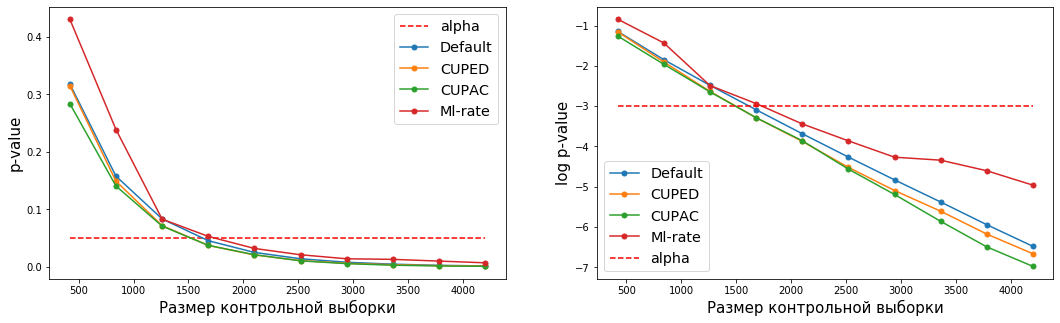

In [183]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

## Маленький исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [184]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]
    
    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist.sample(450, random_state=1)
    hist_e = treatment_sample_hist.sample(int(scale * 450), random_state=1)
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, hist_c, hist_e, cols3)

    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

  0%|          | 0/10 [00:00<?, ?it/s]


 Маленькие фолды: 420
Маленькая история: 3000 



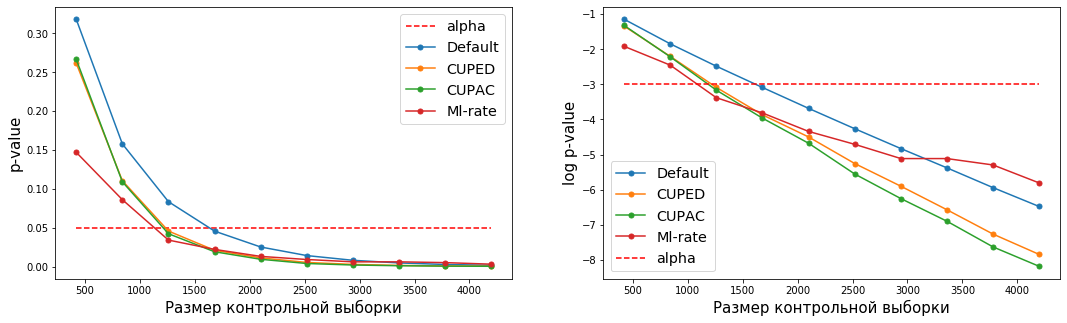

In [185]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

## Большой исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [186]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]
    
    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist
    hist_e = treatment_sample_hist
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, hist_c, hist_e, cols3)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

  0%|          | 0/10 [00:00<?, ?it/s]


 Маленькие фолды: 420
Маленькая история: 6986 



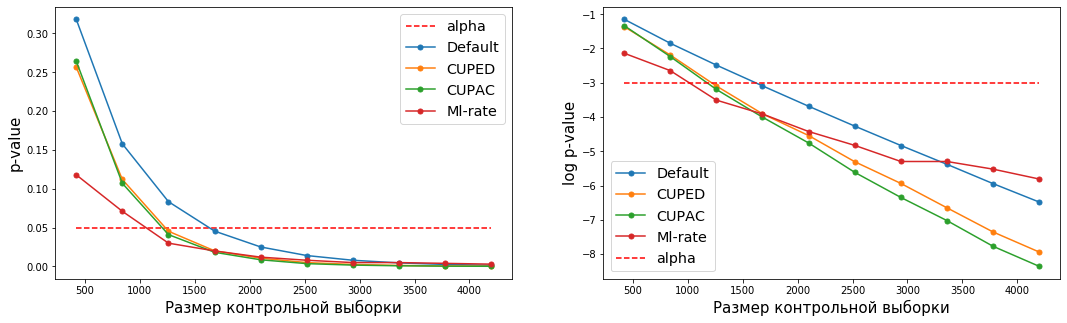

In [187]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

# Эксперимент по сравнению методов, описанный в разделе 3.4.1 отчета о НИР

In [76]:
sizes = [400, 800, 1000, 1200, 1500, 2000]

In [77]:
columns = ['f0', 'f2', 'f8', 'f9']

Для данного эксперимента было сгенерированно по 10 стратифицированных подвыборок с размерами контрольной группы `400, 800, 1000, 1200, 1500, 2000`. На каждой паре подвыборки из тестовой и контрольной групп замерялось p-value до и после применения различных методов снижения дисперсии. По 10 запускам был оценен разброс значений. 

Генерация стратифицированных подвыборок проиводилась с помощью MultilabelStratifiedShuffleSplit

In [6]:
# all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
# all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]
# scale = all_treatment.shape[0] / all_control.shape[0]

# control_generators = []
# treatment_generators = []

# for size in tqdm(sizes):
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size, random_state=size + 5)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=int(size * scale), random_state=size + 5)
    
#     control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
    
#     data_control = []
#     data_treatment = []

#     for i in tqdm(range(0, len(control_indexes))):
#         data_control.append(all_control.iloc[control_indexes[i][1]])
#         data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])
    
#     print(control_indexes[0][1].shape)

#     joblib.dump(data_control, f'control_data_split_{size}.joblib')
#     joblib.dump(data_treatment, f'treatment_data_split_{size}.joblib')
    
    

Генерация исторических данных. Из всего датасета удаляютсяя индексы объектов из тестовой и контрольной выборок одного размера, после чего из оставшихся объектов выбираются пользователи, составляющие исторический контекст.

In [5]:
# history_size = 1000
# history_scale = scale

# for size in tqdm(sizes):
#     control_ind = joblib.load(f'control_data_split_{size}.joblib')
#     treatment_ind = joblib.load(f'treatment_data_split_{size}.joblib')
    
#     all_in_slit_control = []
#     all_in_slit_treatment = []
    
#     for i in range(0, len(control_ind)):
#         all_in_slit_control.extend(control_ind[i].index)
#         all_in_slit_treatment.extend(treatment_ind[i].index)
        
        
#     all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(all_in_slit_control))]
#     all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(all_in_slit_treatment))]
     
    
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=history_size, random_state=size + 2)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=int(history_size * history_scale), random_state=size + 2)
    
#     control_generator = msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
#     print(control_indexes[0][1].shape)
    
#     hist_control_table = []
#     hist_treatment_table = []
    
#     for i in range(0, len(control_indexes)):
#         hist_control_table.append(all_control_for_hist.iloc[control_indexes[i][1]])
#         hist_treatment_table.append(all_treatment_for_hist.iloc[treatment_indexes[i][1]])


        
        
#     joblib.dump(hist_control_table, f'control_data_hist_{size}.joblib')
#     joblib.dump(hist_treatment_table, f'treatment_data_hist_{size}.joblib')
    

In [196]:
def run_test(sample_c, sample_t, history_c_ind, history_t_ind):
    """
    Функция для запуска тестов

    Параметры:
        sample_c - list[DataFrame] - объекты контрольной группы
        sample_t - list[DataFrame] - объекты тестовой группы
        history_c_ind - list[DataFrame] - историческая выборка
        history_t_ind - list[DataFrame] - историческая выборка
        
    Выход:
        before - array - значения p-value без применения методов 
        after_cup - array - значения p-value после применения CUPED 
        after_gb - array - значения p-value после применения CUPAC  
        after_reg - array - значения p-value после применения ML-rate  

    """
    before = []
    after_cup = []
    after_gb = []
    after_reg = []

    cols1 = cols_regr_ordinal
    cols2 = cols_boosting
    cols3 = ['f4', 'f11', 'f2']
    
    
    for i in tqdm(range(0, len(sample_c))):
        test_control = sample_c[i]
        test_treatment = sample_t[i]
        
        hist_control = history_c_ind[i]
        hist_treatment = history_t_ind[i]
        
        
        p_bef, p_after_cup = modify_with_cuped(test_control, test_treatment, hist_control, hist_treatment, cols1, True, encoder='Ord')
        p_bef, p_after_gb = modify_with_gb(test_control, test_treatment, hist_control, hist_treatment, cols2)
        p_aft_reg = modify_with_regression_test(test_control, test_treatment, hist_control, hist_treatment, cols3)

        
        before.append(p_bef)
        after_cup.append(p_after_cup)
        after_gb.append(p_after_gb)
        after_reg.append(p_aft_reg)
        
    return np.array(before), np.array(after_cup), np.array(after_gb), np.array(after_reg)

In [197]:
sizes = [400, 800, 1000, 1200, 1500, 2000]

pvals_b = []
pvals_c = []
pvals_gb = []
pvals_reg = []

# Закгрузка сгенерированных данных в формате list[DataFrame] и запуск тестов
for size in tqdm(sizes):
    control_ind = joblib.load(f'saved_variables/control_data_split_{size}.joblib')
    treatment_ind = joblib.load(f'saved_variables/treatment_data_split_{size}.joblib')
    
    control_ind_hist = joblib.load(f'saved_variables/control_data_hist_{size}.joblib')
    treatment_ind_hist = joblib.load(f'saved_variables/treatment_data_hist_{size}.joblib')
    
    b, c, gb, reg = run_test(control_ind, treatment_ind, control_ind_hist, treatment_ind_hist)
    
    pvals_b.append(b)
    pvals_c.append(c)
    pvals_gb.append(gb)
    pvals_reg.append(reg)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [198]:
# Модификации для отрисовки графика

pvals_c = pd.DataFrame(pvals_c)
pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(pvals_gb)
pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(pvals_b)
pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(pvals_reg)
pvals_reg = pvals_reg.set_axis(sizes)

In [199]:
data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

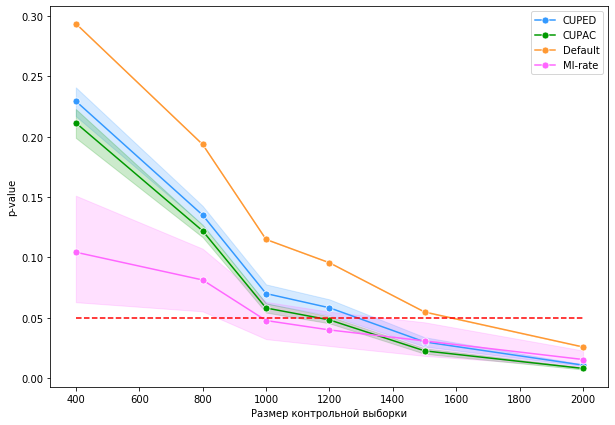

In [200]:
f = plt.subplots(1, figsize=(10, 7))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='CUPAC', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Default', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Ml-rate', marker="o", markersize=7, color='#ff66ff')
plt.plot(sizes, [0.05] * len(sizes), color="#ff0000", linestyle='dashed', label='alpha')
# plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')

plt.show()

# A/A тест на данных Criteo из раздела 3.6 отчета о НИР.

В данной секции мы проверяем, что методы снижения дисперсии CUPED/CUPAC/ML-RATE не приводят к ложноположительным результатам T-теста. Для этого мы анализируем работу методов на выборках без статистически значимой разницы: проводим T-тест на двух контрольных подвыборках одинакового размера.

In [118]:
def run_test_AA(sample, history, n_pairs=45):
    """
    Функция для запуск методов на всех парах одинакового размера из котнтрольной группы.        
    
    Параметры:
        sample - list[DataFrame] - объекты контрольной группы
        history - list[DataFrame] - историческая выборка
        
    Выход:
        before - array - значения p-value без применения методов 
        after_cup - array - значения p-value после применения CUPED 
        after_gb - array - значения p-value после применения CUPAC  
        after_reg - array - значения p-value после применения ML-rate  

    """
    before = []
    after_cup = []
    after_gb = []
    after_reg = []

    cols1 = cols_regr_ordinal
    cols2 = cols_boosting
    cols3 = ['f4', 'f11', 'f2']
    
    

    indexes = list(range(0, len(sample)))

    pairs = np.array(list((itertools.combinations(indexes, 2))))
    chosen_indexes = np.random.choice(np.arange(0, len(pairs)), n_pairs, replace=False)
    chosen_pairs = pairs[chosen_indexes]
    
    for pair in tqdm(chosen_pairs):
        test_control = sample[pair[0]]
        test_treatment = sample[pair[1]]
        
        hist_control = history[pair[0]]
        hist_treatment = history[pair[1]]
        
        p_bef, p_after_cup = modify_with_cuped(test_control, test_treatment, hist_control, hist_treatment, cols1, True, encoder='Ord')
        p_bef, p_after_gb = modify_with_gb(test_control, test_treatment, hist_control, hist_treatment, cols2)
        p_aft_reg = modify_with_regression_test(test_control, test_treatment, hist_control, hist_treatment, cols3, aa=True)
        
        before.append(p_bef)
        after_cup.append(p_after_cup)
        after_gb.append(p_after_gb)
        after_reg.append(p_aft_reg)
        
    return np.array(before), np.array(after_cup), np.array(after_gb), np.array(after_reg)

In [119]:
# Запуск методов на данных без статистически значимой разницы
# control_ind - list[DataFrame] - контрольная выборка
# control_ind_hist - list[DataFrame] - исторические выборки
# На выходе - 4 array[list[float]] - 4 листа с значением p-value для каждого метода для каждой пары

sizes = [400, 800, 1000, 1200, 1500, 2000]

pvals_b = []
pvals_c = []
pvals_gb = []
pvals_reg = []

for size in tqdm(sizes):
    control_ind = joblib.load(f'saved_variables/control_data_split_{size}_notarget.joblib')
    
    control_ind_hist = joblib.load(f'saved_variables/control_data_hist_{size}_notarget.joblib')
    
    b, c, gb, reg = run_test_AA(control_ind, control_ind_hist)
    
    pvals_b.append(b)
    pvals_c.append(c)
    pvals_gb.append(gb)
    pvals_reg.append(reg)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [120]:
# Модификациии для отрисовки графика

pvals_c = pd.DataFrame(pvals_c)
pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(pvals_gb)
pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(pvals_b)
pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(pvals_reg)
pvals_reg = pvals_reg.set_axis(sizes)

In [121]:
# Модификациии для отрисовки графика

data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

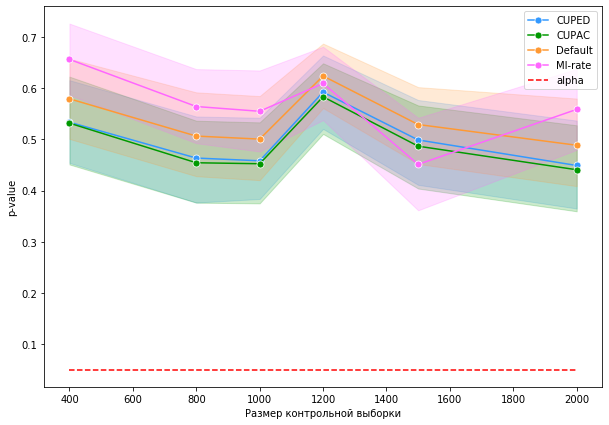

In [86]:
f = plt.subplots(1, figsize=(10, 7))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='CUPAC', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Default', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Ml-rate', marker="o", markersize=7, color='#ff66ff')

plt.plot(sizes, [0.05] * len(sizes), color="#ff0000", linestyle='dashed', label='alpha')
# plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')
plt.legend()
plt.show()